In [2]:
import yfinance as yf
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import conf
import pyfolio as pf
from util import preprocessing
from new_env import StockPortfolioEnv
from finrl.meta.preprocessor.preprocessors import FeatureEngineer
from finrl.agents.stablebaselines3.models import DRLAgent
from stable_baselines3 import A2C, PPO
from pypfopt.efficient_frontier import EfficientFrontier
from pypfopt import risk_models,expected_returns, objective_functions
from pyfolio import timeseries
from backtest import BackTestStats, BaselineStats, BackTestPlot, backtest_strat, baseline_strat

%matplotlib inline 

c:\Users\nolan\AppData\Local\Programs\Python\Python310\lib\site-packages\pyfolio\pos.py:25: UserWarning: Module "zipline.assets" not found; multipliers will not be applied to position notionals.
  warnings.warn(


In [3]:
df = pd.read_csv('raw_data.csv', index_col=0)
fe = FeatureEngineer(tech_indicator_list=conf.TA_LIST)

df = fe.preprocess_data(df)
df = df.sort_values(['date', 'ticker']).reset_index(drop=True)
df.index = df.date.factorize()[0]
df = preprocessing(df)

Successfully added technical indicators


In [4]:
df_test = df[df['date'] >= '2022-01-01']
df_test = df_test.sort_values(['date', 'ticker']).reset_index(drop=True)
df_test.index = df_test.date.factorize()[0]
df_test.head()

,date,ticker,open,high,low,close,volume,day,rsi,macd,cci,atr,adx,sma,ema,obv,cov_list
0,2022-01-03,AAPL,177.830002,182.880005,177.710007,180.434296,104487900,0,66.613017,4.786703,108.693392,4.646072,52.559252,176.424871,176.474275,98167543400,"[[0.0002495422734495149, 0.0001423948493936616..."
0,2022-01-03,AMZN,167.550003,170.703506,166.160507,170.404495,63520000,0,48.622296,-1.231128,-24.193272,4.074268,8.949928,169.757777,169.523506,22915150000,"[[0.0002495422734495149, 0.0001423948493936616..."
0,2022-01-03,BRK-B,300.100006,301.299988,299.200012,300.790009,3570300,0,64.875653,3.962497,98.739398,3.821770,46.006927,297.370002,297.621625,812310700,"[[0.0002495422734495149, 0.0001423948493936616..."
0,2022-01-03,GOOG,144.475494,145.550003,143.502502,145.074493,25214000,0,48.010599,-0.013619,-31.961908,2.632496,13.160649,146.120556,145.720813,27601502767,"[[0.0002495422734495149, 0.0001423948493936616..."
0,2022-01-03,LIN,346.420013,346.589996,338.359985,331.055450,1514700,0,54.535226,4.353743,32.659128,10.067444,29.349115,333.408234,333.403141,153556000,"[[0.0002495422734495149, 0.0001423948493936616..."


In [5]:
stock_dim = len(conf.TICKERS)
env_kwargs = {
    'share_max': 5000,
    'initial_amount': 1000,
    'transaction_cost_pct': 0,
    'state_space': stock_dim,
    'action_space': stock_dim,
    'stock_dim': stock_dim,
    'tech_indicator_list': conf.TA_LIST,
    'reward_scaling': 0,
    'initial_weights': [1/stock_dim] * stock_dim
}

# Testing Portfolio

## Modern Portfolio Theory

In [6]:
# Reset the Index to tic and date
df_prices = df.reset_index().set_index(['ticker', 'date']).sort_index()

# Get all the Close Prices
mpt_df_base = pd.DataFrame()

for ticker in conf.TICKERS:
    series = df_prices.xs(ticker).close
    mpt_df_base[ticker] = series

mpt_df_train = mpt_df_base[mpt_df_base.index < '2022-01-01']
mpt_df_test = mpt_df_base[mpt_df_base.index >= '2022-01-01']

mpt_df_train 


,AMZN,WMT,XOM,BRK-B,UNH,UPS,AAPL,LIN,PLD,GOOG,NEE
date,,,,,,,,,,,
2005-08-18,2.186500,32.322857,31.948700,56.740002,41.809818,42.911884,1.405441,35.377659,23.667801,6.973611,5.987179
2005-08-19,2.186000,31.871256,32.339039,56.599998,41.712002,42.732563,1.391174,35.328579,23.573946,6.973860,5.987179
2005-08-22,2.188500,31.932852,32.476498,56.400002,41.858711,43.252651,1.392388,35.307556,23.905199,6.824669,6.208223
2005-08-23,2.171000,31.707047,32.438004,56.400002,41.614216,43.109188,1.388442,34.326202,23.965921,6.963399,6.353141
2005-08-24,2.118500,31.166508,32.372021,56.139999,41.263752,43.013550,1.389353,34.340225,24.114992,7.037870,6.318460
...,...,...,...,...,...,...,...,...,...,...,...
2021-12-27,169.669495,137.493591,58.565731,296.670013,489.424469,204.436951,178.768845,335.728424,159.429153,148.063995,88.272377
2021-12-28,170.660995,139.466736,58.376476,298.290009,492.795105,204.028290,177.737839,336.090118,159.333054,146.447998,88.813683
2021-12-29,169.201004,139.398361,57.865482,299.459991,495.381836,203.952271,177.827072,337.664093,161.149445,146.504501,88.920013


In [7]:
mu = expected_returns.mean_historical_return(mpt_df_train)
Sigma = risk_models.sample_cov(mpt_df_train)
ef = EfficientFrontier(mu,Sigma)
ef.add_objective(objective_functions.L2_reg, gamma=1)

raw_weights = ef.max_sharpe(risk_free_rate=0.05)
cleaned_weights = ef.clean_weights()
max_sharpe_portfolio = pd.DataFrame(cleaned_weights, index=[0])

_ = ef.portfolio_performance(verbose=True, risk_free_rate=0.05)

print("max sharpe portfolio:")
max_sharpe_portfolio

Expected annual return: 24.2%
Annual volatility: 22.4%
Sharpe Ratio: 0.86
max sharpe portfolio:


c:\Users\nolan\AppData\Local\Programs\Python\Python310\lib\site-packages\pypfopt\efficient_frontier\efficient_frontier.py:259: UserWarning: max_sharpe transforms the optimization problem so additional objectives may not work as expected.
  warnings.warn(


,AMZN,WMT,XOM,BRK-B,UNH,UPS,AAPL,LIN,PLD,GOOG,NEE
0,0.2177,0.02875,0.0,0.03589,0.0848,0.02485,0.26942,0.07181,0.02564,0.12304,0.11809


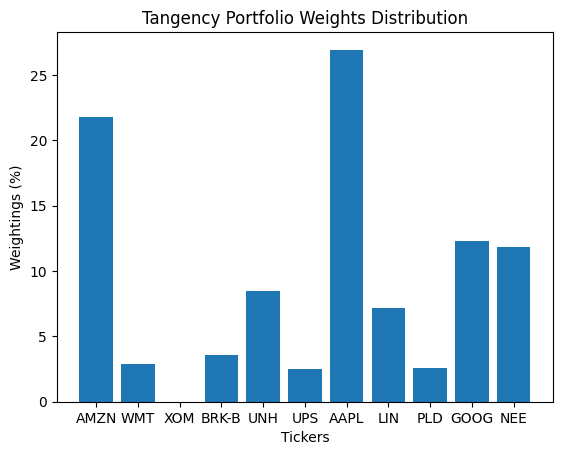

In [39]:
plt.bar(x=max_sharpe_portfolio.columns, height=max_sharpe_portfolio.iloc[0,:]*100)
plt.xlabel('Tickers')
plt.ylabel('Weightings (%)')
plt.title('Tangency Portfolio Weights Distribution');

## PPO Test

In [9]:
test_env = StockPortfolioEnv(df = df_test, **env_kwargs)

In [10]:
agent = DRLAgent(env=test_env)
trained_ppo = PPO.load('./models/PPO_1.0/finished_training.zip')

In [11]:
ppo_test_daily_return, ppo_test_weights = DRLAgent.DRL_prediction(model=trained_ppo, environment=test_env)

c:\Users\nolan\AppData\Local\Programs\Python\Python310\lib\site-packages\stable_baselines3\common\vec_env\patch_gym.py:49: UserWarning: You provided an OpenAI Gym environment. We strongly recommend transitioning to Gymnasium environments. Stable-Baselines3 is automatically wrapping your environments in a compatibility layer, which could potentially cause issues.
  warnings.warn(


begin_total_asset:1000
end_total_asset:1035.720829909356
Sharpe:  0.21705042709846387
hit end!


In [12]:
ppo_test_daily_return

,date,daily_return
0,2022-01-03,0.000000
1,2022-01-04,-0.001538
2,2022-01-05,-0.010100
3,2022-01-06,-0.008716
4,2022-01-07,0.000414
...,...,...
370,2023-06-26,-0.000035
371,2023-06-27,0.006730
372,2023-06-28,0.001183
373,2023-06-29,0.000967


## A2C Test

In [13]:
test_env = StockPortfolioEnv(df = df_test, **env_kwargs)

In [14]:
agent = DRLAgent(env=test_env)
trained_a2c = A2C.load('./models/A2C/finished_training.zip')

In [15]:
a2c_test_daily_return, a2c_test_weights = DRLAgent.DRL_prediction(model=trained_a2c, environment=test_env)

c:\Users\nolan\AppData\Local\Programs\Python\Python310\lib\site-packages\stable_baselines3\common\vec_env\patch_gym.py:49: UserWarning: You provided an OpenAI Gym environment. We strongly recommend transitioning to Gymnasium environments. Stable-Baselines3 is automatically wrapping your environments in a compatibility layer, which could potentially cause issues.
  warnings.warn(


begin_total_asset:1000
end_total_asset:1027.949296362425
Sharpe:  0.19520577902669642
hit end!


## S&P 500

In [16]:
sp500 = yf.download("^GSPC",
                    start='2022-01-01',
                    end='2023-07-01')

[*********************100%***********************]  1 of 1 completed


In [17]:
sp500_daily_return = sp500['Adj Close'].pct_change()

In [18]:
sp500_daily_return.fillna(0, inplace=True)
sp500_daily_return

Date
2022-01-03    0.000000
2022-01-04   -0.000630
2022-01-05   -0.019393
2022-01-06   -0.000964
2022-01-07   -0.004050
                ...   
2023-06-26   -0.004487
2023-06-27    0.011456
2023-06-28   -0.000354
2023-06-29    0.004474
2023-06-30    0.012269
Name: Adj Close, Length: 375, dtype: float64

In [19]:
returns_test = mpt_df_test.pct_change()

In [20]:
max_sharpe_weights = max_sharpe_portfolio.values.flatten()
max_sharpe_returns = returns_test.dot(max_sharpe_weights)
max_sharpe_cum_returns = (1 + max_sharpe_returns).cumprod()

In [21]:
max_sharpe_returns.fillna(0, inplace=True)
max_sharpe_returns

date
2022-01-03    0.000000
2022-01-04   -0.009304
2022-01-05   -0.018450
2022-01-06   -0.016106
2022-01-07   -0.001902
                ...   
2023-06-26   -0.007978
2023-06-27    0.008833
2023-06-28    0.001396
2023-06-29   -0.002027
2023-06-30    0.016422
Length: 375, dtype: float64

In [22]:
a2c_test_daily_return = a2c_test_daily_return.set_index('date').squeeze()
a2c_test_daily_return

date
2022-01-03    0.000000
2022-01-04   -0.000672
2022-01-05   -0.013991
2022-01-06   -0.004478
2022-01-07   -0.000864
                ...   
2023-06-26    0.000265
2023-06-27    0.008161
2023-06-28    0.003267
2023-06-29    0.001176
2023-06-30    0.013579
Name: daily_return, Length: 375, dtype: float64

In [23]:
ppo_test_daily_return = ppo_test_daily_return.set_index('date').squeeze()
ppo_test_daily_return

date
2022-01-03    0.000000
2022-01-04   -0.001538
2022-01-05   -0.010100
2022-01-06   -0.008716
2022-01-07    0.000414
                ...   
2023-06-26   -0.000035
2023-06-27    0.006730
2023-06-28    0.001183
2023-06-29    0.000967
2023-06-30    0.013587
Name: daily_return, Length: 375, dtype: float64

# Compare Models with MPT

In [24]:
tangency_port_value = 1000
a2c_port_value = 1000
ppo_port_value = 1000
sp500_port_value =1000

tangency_port_daily_value = []
a2c_port_daily_value = []
ppo_port_daily_value = []
sp500_port_daily_value = []

In [25]:
for i in range(375):
    tangency_port_value = tangency_port_value + tangency_port_value*max_sharpe_returns[i]
    tangency_port_daily_value.append(tangency_port_value)

    a2c_port_value = a2c_port_value + a2c_port_value*a2c_test_daily_return[i]
    a2c_port_daily_value.append(a2c_port_value)

    ppo_port_value = ppo_port_value + ppo_port_value*ppo_test_daily_return[i]
    ppo_port_daily_value.append(ppo_port_value)

    sp500_port_value = sp500_port_value + sp500_port_value*sp500_daily_return[i]
    sp500_port_daily_value.append(sp500_port_value)

In [26]:
tangency_port_daily_value = pd.Series(tangency_port_daily_value, name='Tangency Portfolio')
a2c_port_daily_value = pd.Series(a2c_port_daily_value, name='A2C Portfolio')
ppo_port_daily_value = pd.Series(ppo_port_daily_value, name='PPO Portfolio')
sp500_port_daily_value = pd.Series(sp500_port_daily_value, name='S&P 500 Portfolio')

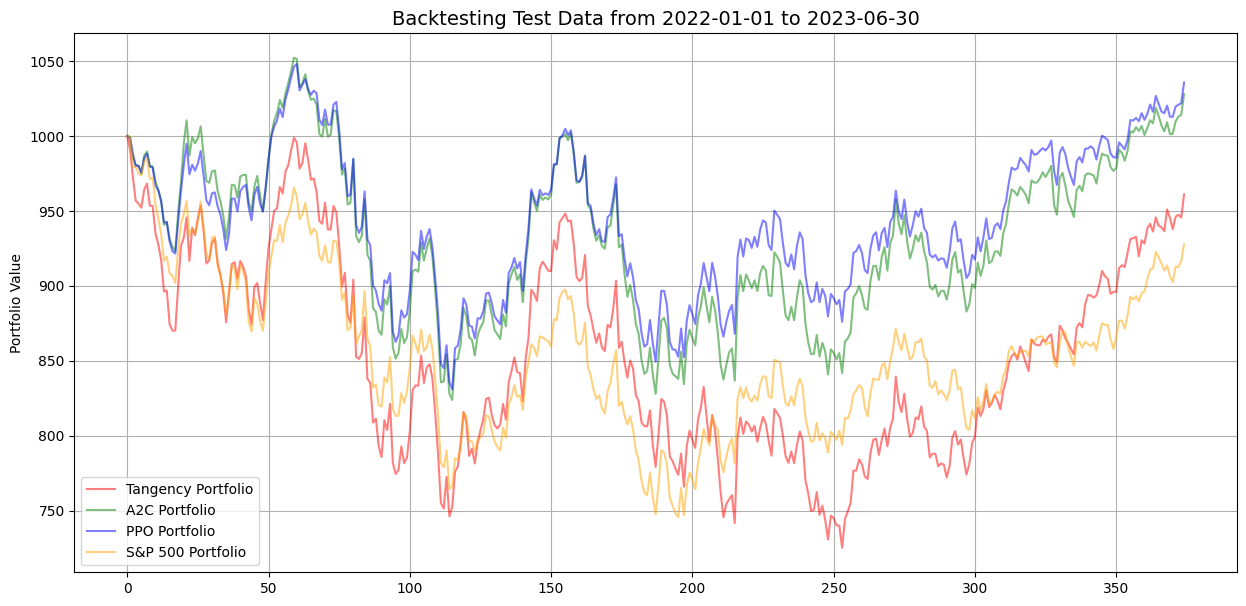

In [27]:
fig, ax = plt.subplots(figsize=(15,7))

tangency_port_daily_value.plot(x=tangency_port_daily_value.index, ax=ax, color='red', alpha=0.5)
a2c_port_daily_value.plot(x=a2c_port_daily_value.index, ax=ax, color='green', alpha=0.5)
ppo_port_daily_value.plot(x=ppo_port_daily_value.index, ax=ax, color='blue', alpha=0.5)
sp500_port_daily_value.plot(x=sp500_port_daily_value.index, ax=ax, color='orange', alpha=0.5)

plt.legend(loc="best");
plt.grid(True);
ax.set_ylabel("Portfolio Value");
ax.set_title("Backtesting Test Data from 2022-01-01 to 2023-06-30", fontsize=14);
fig.savefig('results/test_data_backtest.png');

# Compare to SP 500

In [28]:
ppo_test_daily_return_df = pd.DataFrame(ppo_test_daily_return).reset_index()
ppo_test_daily_return_df.columns = ['date', 'daily_return']
ppo_test_daily_return_df

,date,daily_return
0,2022-01-03,0.000000
1,2022-01-04,-0.001538
2,2022-01-05,-0.010100
3,2022-01-06,-0.008716
4,2022-01-07,0.000414
...,...,...
370,2023-06-26,-0.000035
371,2023-06-27,0.006730
372,2023-06-28,0.001183
373,2023-06-29,0.000967


In [29]:
ppo_strat = backtest_strat(ppo_test_daily_return_df)
perf_func = timeseries.perf_stats 
perf_stats_all = perf_func( returns=ppo_strat, 
                              factor_returns=ppo_strat, 
                                positions=None, transactions=None, turnover_denom="AGB")

In [30]:
sp500, sp500_strat = baseline_strat('^GSPC',"2022-01-01", "2023-07-01")

[*********************100%***********************]  1 of 1 completed
Shape of DataFrame:  (375, 8)


Start date,2022-01-03
End date,2023-06-30
Total months,17
,Backtest
Annual return,2.387%
Cumulative returns,3.572%
Annual volatility,20.922%
Sharpe ratio,0.22
Calmar ratio,0.12
Stability,0.01
Max drawdown,-20.713%


Worst drawdown periods,Net drawdown in %,Peak date,Valley date,Recovery date,Duration
0,20.71,2022-03-30,2022-06-17,NaT,NaN
1,7.84,2022-01-03,2022-01-27,2022-03-18,55
2,0.56,2022-03-22,2022-03-23,2022-03-24,3
3,NaN,NaT,NaT,NaT,NaN
4,NaN,NaT,NaT,NaT,NaN


ConversionError: Failed to convert value(s) to axis units: (NaT, Timestamp('2023-06-30 00:00:00+0000', tz='UTC'))

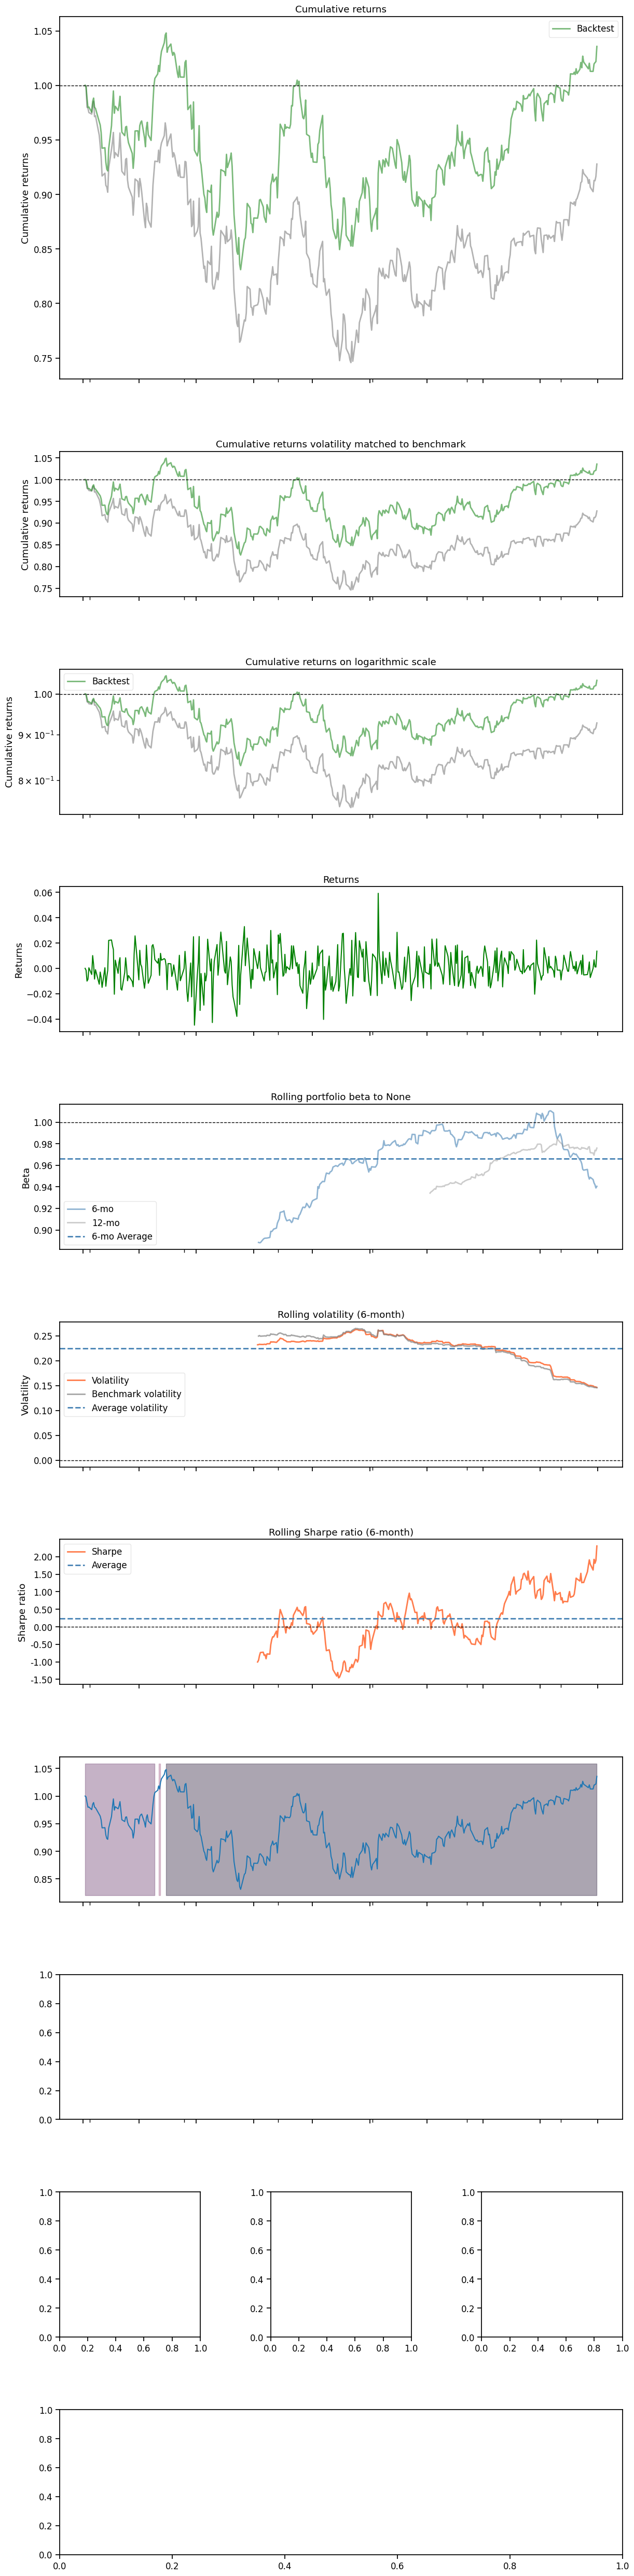

In [31]:
with pf.plotting.plotting_context(font_scale=1.1):
        pf.create_full_tear_sheet(returns = ppo_strat,
                                       benchmark_rets=sp500_strat, set_context=False)

# Stats Summary

In [ ]:
def portfolio_stats(portfolio_returns):
    # Pass the returns into a dataframe
    port_rets_df = pd.DataFrame(portfolio_returns)
    port_rets_df = port_rets_df.reset_index()
    port_rets_df.columns = ['date','daily_return']
    
    #Use the FinRL Library to get the Portfolio Returns
    #This makes use of the Pyfolio Library
    
    DRL_strat = backtest_strat(port_rets_df)
    perf_func = timeseries.perf_stats 
    perf_stats_all = perf_func( returns=DRL_strat, 
                                  factor_returns=DRL_strat, 
                                    positions=None, transactions=None, turnover_denom="AGB")
    perf_stats_all = pd.DataFrame( perf_stats_all)
    perf_stats_all.columns = ['Statistic']
    return perf_stats_all

In [ ]:
portfolios_returns_dict = {'Tangency Portfolio':max_sharpe_returns,
                          'A2C Portfolio': a2c_test_daily_return,
                          'PPO Portfolio': ppo_test_daily_return,
                          'S&P 500 Index': sp500_daily_return}

portfolios_stats = pd.DataFrame()
for i,j in portfolios_returns_dict.items():
    port_stats = portfolio_stats(j)
    portfolios_stats[i] = port_stats['Statistic']

In [ ]:
portfolios_stats

,Tangency Portfolio,A2C Portfolio,PPO Portfolio,S&P 500 Index
Annual return,-0.026348,0.018697,0.023866,-0.049093
Cumulative returns,-0.038955,0.027949,0.035721,-0.072173
Annual volatility,0.262504,0.229904,0.209221,0.214830
Sharpe ratio,0.029141,0.195206,0.217050,-0.127097
Calmar ratio,-0.095893,0.086153,0.115222,-0.193090
Stability,0.086239,0.004279,0.006460,0.110366
Max drawdown,-0.274768,-0.217019,-0.207129,-0.254251
Omega ratio,1.004801,1.033010,1.036641,0.979338
Sortino ratio,0.041646,0.280891,0.313007,-0.178975
Skew,0.076670,0.038188,0.034981,-0.030266
